In [195]:
# SARIMAX AVEC AUTO ARIMA PARAMS

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [197]:
uber = pd.read_csv('../uber_data.csv', parse_dates= True)

In [198]:
uber.head()

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


In [199]:
uber = uber.dropna()

In [200]:
manhattan = uber[uber['borough'] == 'Manhattan']
manhattan

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
10,2015-01-01 02:00:00,Manhattan,4345,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,Y
17,2015-01-01 03:00:00,Manhattan,4577,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,Y
24,2015-01-01 04:00:00,Manhattan,3003,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,Y
31,2015-01-01 05:00:00,Manhattan,1313,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29071,2015-06-30 19:00:00,Manhattan,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,N
29078,2015-06-30 20:00:00,Manhattan,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,N
29085,2015-06-30 21:00:00,Manhattan,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,N
29091,2015-06-30 22:00:00,Manhattan,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,N


In [201]:
manhattan = manhattan.set_index('pickup_dt', drop=True)

In [202]:
#manhattan = manhattan.drop('hday', axis=1)

In [203]:
manhattan = manhattan.drop('borough', axis=1)

In [204]:
manhattan = pd.get_dummies(manhattan)

In [205]:
manhattan

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday_N,hday_Y
pickup_dt,,,,,,,,,,,,
2015-01-01 01:00:00,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,0,1
2015-01-01 02:00:00,4345,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,0,1
2015-01-01 03:00:00,4577,5.0,10.0,30.0,8.0,1022.3,0.0,0.0,0.0,0.0,0,1
2015-01-01 04:00:00,3003,5.0,10.0,29.0,9.0,1022.0,0.0,0.0,0.0,0.0,0,1
2015-01-01 05:00:00,1313,5.0,10.0,28.0,9.0,1021.8,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30 19:00:00,4585,5.0,10.0,80.0,58.0,1012.5,0.0,0.0,0.0,0.0,1,0
2015-06-30 20:00:00,4210,8.0,10.0,80.0,58.0,1012.4,0.0,0.0,0.0,0.0,1,0
2015-06-30 21:00:00,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,1,0


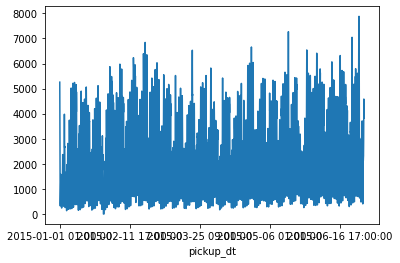

In [206]:
manhattan['pickups'].plot()

In [207]:
#donne le prix du jour d'apres car cela va etre le prix à prédire 
steps = -1
manhattan['actual'] = manhattan['pickups'].shift(steps)
manhattan.tail(3)

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday_N,hday_Y,actual
pickup_dt,,,,,,,,,,,,,
2015-06-30 21:00:00,4313,7.0,10.0,76.0,61.0,1012.4,0.0,0.0,0.0,0.0,1,0,4452.0
2015-06-30 22:00:00,4452,5.0,10.0,76.0,64.0,1011.9,0.0,0.0,0.0,0.0,1,0,3828.0
2015-06-30 23:00:00,3828,7.0,10.0,75.0,65.0,1011.8,0.0,0.0,0.0,0.0,1,0,NaN


In [208]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0,1))
scaled_input = sc_in.fit_transform(manhattan[['pickups','temp','pcp01','hday_N']])
scaled_input= pd.DataFrame(scaled_input)
X = scaled_input
#X.rename(columns={0:'pickups',1:'temp'}, inplace = True)
X.columns = ['pickups','temp','pcp01','hday_N']
X

,pickups,temp,pcp01,hday_N
0,0.667005,0.321839,0.0,0.0
1,0.551186,0.321839,0.0,0.0
2,0.580617,0.321839,0.0,0.0
3,0.380946,0.310345,0.0,0.0
4,0.166561,0.298851,0.0,0.0
...,...,...,...,...
4338,0.581631,0.896552,0.0,1.0
4339,0.534061,0.896552,0.0,1.0
4340,0.547127,0.850575,0.0,1.0
4341,0.564760,0.850575,0.0,1.0


In [209]:
sc_out = MinMaxScaler(feature_range=(0,1))
scaler_output = sc_out.fit_transform(manhattan[['actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y.rename(columns={0:'pickups_hour_after'}, inplace = True)
y

,pickups_hour_after
0,0.551186
1,0.580617
2,0.380946
3,0.166561
4,0.085247
...,...
4338,0.534061
4339,0.547127
4340,0.564760
4341,0.485602


In [210]:
#train_size = int(len(manhattan)*0.7)
#test_size = int(len(manhattan)) - train_size

train_size = int(len(manhattan)-720)
test_size = int(len(manhattan)) - train_size

X_train, y_train = X[:train_size].dropna(), y[:train_size].dropna()
X_test, y_test = X[train_size:].dropna(), y[train_size:].dropna()

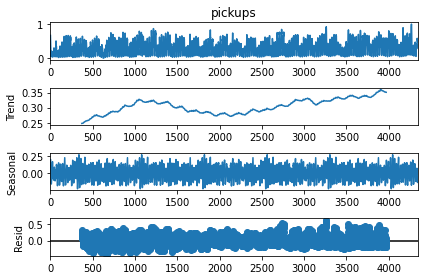

In [211]:
from statsmodels.tsa.seasonal import seasonal_decompose

sd = seasonal_decompose(X['pickups'], model= 'add', period=742)

fig = sd.plot()
fig.set_figheight(4)
plt.show()

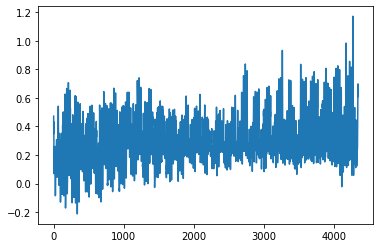

In [212]:
x =  sd.observed - sd.seasonal
x.plot()

In [213]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'Valeur critique ({key})']=val
    if dftest[1]<=0.05:
        print("Preuves contre la null hypothesis")
        print("On rejette la null hypothesis - les données sont stationaire")
    else:
        print("Preuves pour la null hypothesis")
        print("On accept la null hypothesis - les données ne sont pas stationaire")

In [214]:
test = y['pickups_hour_after'][:train_size].dropna()
test_adf(test,'pickups')

Preuves contre la null hypothesis
On rejette la null hypothesis - les données sont stationaire


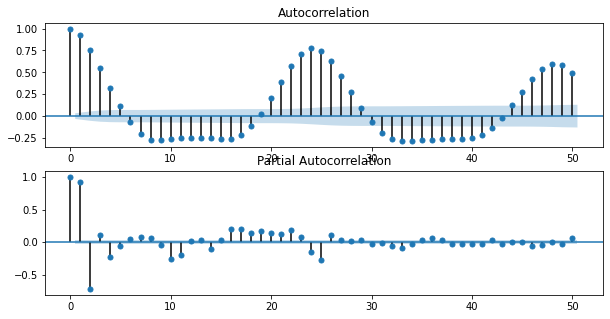

In [215]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(test, lags=50, ax=ax[1])
plt.show()

In [216]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
 exogenous= X_train,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11514.546, Time=4.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11215.543, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11418.629, Time=3.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11516.424, Time=3.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11217.530, Time=1.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11514.624, Time=5.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11667.289, Time=7.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11516.742, Time=6.79 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11517.700, Time=8.57 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-11518.013, Time=7.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11516.971, Time=6.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11516.556, Time=9.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=6.35 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 70.844 seconds


In [217]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3623
Model:               SARIMAX(1, 1, 2)   Log Likelihood                5842.644
Date:                Sun, 18 Oct 2020   AIC                         -11667.289
Time:                        17:07:57   BIC                         -11611.536
Sample:                             0   HQIC                        -11647.426
                               - 3623                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.917e-05      0.000      0.656      0.512      -0.000       0.000
pickups        0.5550      0.050     11.163      0.000       0.458       0.652
temp           0.5059      0.044     11.472      0.000       0.419       0.592
pcp01          0.0870      0.012      7.348      0.000       0.064       0.110
hday_N         0.0247      0.014      1.760      0.078      -0.003       0.052
ar.L1          0.6643      0.051     13.007      0.000       0.564       0.764
ma.L1         -0.4574      0.019    -23.961      0.000      -0.495      -0.420
ma.L2         -0.4252      0.013    -33.442      0.000      -0.450      -0.400
sigma2         0.0024    3.8e-05     63.536      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                     2100.67   Jarque-Bera (JB):              2260.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.26
Prob(H) (two-sided):                  0.32   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [218]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(y_train, 
 exog=X_train,
 order=(1,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

In [219]:
X_train

,pickups,temp,pcp01,hday_N
0,0.667005,0.321839,0.000000,0.0
1,0.551186,0.321839,0.000000,0.0
2,0.580617,0.321839,0.000000,0.0
3,0.380946,0.310345,0.000000,0.0
4,0.166561,0.298851,0.000000,0.0
...,...,...,...,...
3618,0.627172,0.842912,0.107143,1.0
3619,0.520107,0.833333,0.053571,1.0
3620,0.461626,0.789272,1.000000,1.0
3621,0.361284,0.773946,0.904762,1.0


In [220]:
#le nombre d'iteration est de 50 par default ce qui empeche le maximum likehood optimization de converger
#pour résoudre le problème de converger on augment le parametre maxiter de la methode fit
#ca diminue legerement notre erreur :  de 27.15 -> 27.14
results = model.fit(maxiter = 100)

In [221]:
results.mle_retvals

{'fopt': -1.6466978767726685,
 'gopt': array([-3.20823368e-06, -9.31785760e-06,  1.77031056e-05, -1.08756781e-05,
         9.47464329e-07,  7.60254082e-05,  9.82051773e-05, -7.19496662e-04]),
 'fcalls': 1053,
 'warnflag': 0,
 'converged': True,
 'iterations': 90}

In [222]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

In [223]:
predictions

3623    0.052851
3624    0.056805
3625    0.073057
3626    0.085224
3627    0.108050
          ...   
4338    0.500516
4339    0.469417
4340    0.475364
4341    0.486892
4342    0.434494
Length: 720, dtype: float64

In [224]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [225]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=X_test.index
predictions['actual'] = act['pickups_hour_after']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions

,Pred,actual
3623,0.052851,0.089306
3624,0.056805,0.061905
3625,0.073057,0.044272
3626,0.085224,0.057465
3627,0.108050,0.101865
...,...,...
4338,0.500516,0.534061
4339,0.469417,0.547127
4340,0.475364,0.564760
4341,0.486892,0.485602


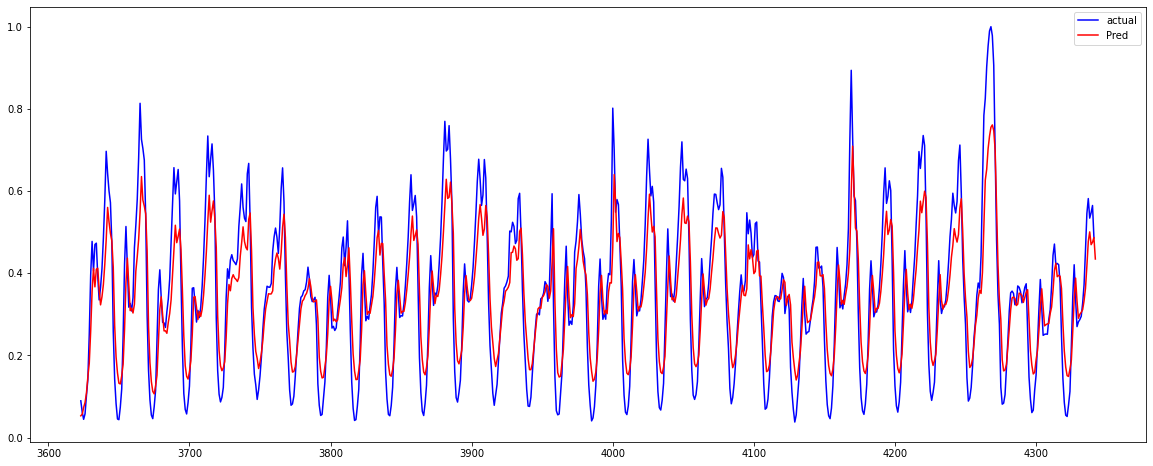

In [226]:
predictions['actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [227]:
test_size

720

In [228]:
forecast= results.forecast(steps=test_size, exog=X_test)

In [229]:
forecast

3623    0.052851
3624    0.056805
3625    0.073057
3626    0.085224
3627    0.108050
          ...   
4338    0.500516
4339    0.469417
4340    0.475364
4341    0.486892
4342    0.434494
Length: 720, dtype: float64

In [230]:
X_test.to_csv('../X_test_sarimax.csv', index=False)

In [231]:
y_test.to_csv('../y_test_sarimax.csv', index=False)

In [232]:
forecast= pd.DataFrame(forecast)
forecast.reset_index(drop=True, inplace=True)
forecast.index=X_test.index
forecast['actual'] =scaler_output.iloc[train_size:, 0]
forecast.rename(columns={0:'Forecast'}, inplace=True)

In [233]:
y_test

,pickups_hour_after
3623,0.089306
3624,0.061905
3625,0.044272
3626,0.057465
3627,0.101865
...,...
4337,0.581631
4338,0.534061
4339,0.547127
4340,0.564760


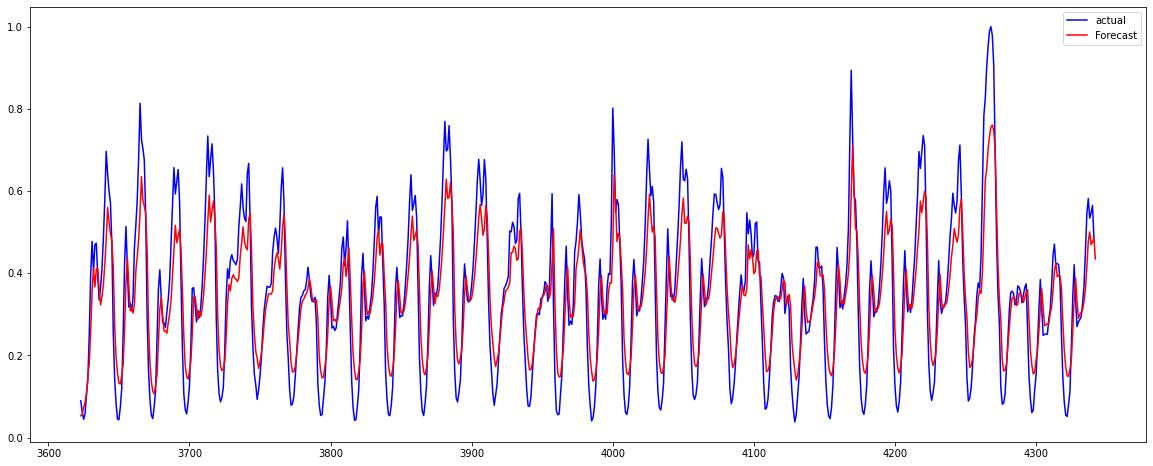

In [234]:
forecast['actual'].plot(figsize=(20,8), legend=True, color='blue')
forecast['Forecast'].plot(legend=True, color='red', figsize=(20,8))

In [235]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['actual']])

In [236]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [237]:
#rajouter la temp et les precipitations à 1h permet de passer de 27.14 -> 26.84

evaluating = smape_perso(trainPredict[:-1], testPredict[:-1])
evaluating

26.843402999443803

In [238]:
import pickle

pickle.dump(results, open('model_sarimax.pkl','wb'))